In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

# Multiclass Classification using CNN
We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes, where as our current model only works with two classes (pizza and steak).

🛠 Practice: Before scrolling down, how do you think we might change our model to work with 10 classes of the same kind of images? Assume the data is in the same style as our two class problem.

Remember the steps we took before to build our pizza 🍕 vs. steak 🥩 classifier?

How about we go through those steps again, except this time, we'll work with 10 different types of food.

- Become one with the data (visualize, visualize, visualize...)
 - Preprocess the data (prepare it for a model)
 - Create a model (start with a baseline)
 - Fit the model
 -  Evaluate the model
 - Adjust different parameters and improve model (try to beat your baseline)
-  Repeat until satisfied


# 1. Import Data 

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", 'r')
zip_ref.extractall()
zip_ref.close

--2021-12-22 17:18:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   165MB/s    in 3.0s    

2021-12-22 17:18:19 (165 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_all_data.zip' mode='r'>>

In [3]:
import os

# walk throught the 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in '10_food_classes_all_data'.
there are 10 directories and 0 images in '10_food_classes_all_data/train'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
there are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [4]:
# set up train and test directory paths
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [5]:
# Let's get the class names
import pathlib

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [6]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 385, 3)


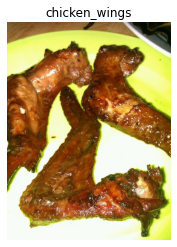

In [7]:
# Visualize random images

import random
img = view_random_image(target_dir = train_dir,
                        target_class = random.choice(class_names))

# 2. Preprocess the Data
After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data. 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# crate train and test data generator and rescale the data
train_datagen = ImageDataGenerator(rescale = 1/225.)
test_datagen = ImageDataGenerator(rescale = 1/225.)

# Load the data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224), 
                                               batch_size=32,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# 3. Create a Baseline Model
We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:

-    Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
-    Changing the output layer to use 'softmax' activation instead of 'sigmoid' activation.
-    Changing the loss function to be 'categorical_crossentropy' instead of 'binary_crossentropy'.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# create our model 
model_9 = Sequential([
                      Conv2D(10,3,activation="relu", input_shape=(224, 224, 3)),
                      Conv2D(10,3, activation='relu'),
                      MaxPool2D(),
                      Conv2D(10, 3, activation="relu"),
                      Conv2D(10,3, activation="relu"),
                      MaxPool2D(),
                      Flatten(),
                      Dense(10, activation='softmax')])

# compile the model
model_9.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 4. Fit the Model

In [10]:
history_9 = model_9.fit(train_data,
            epochs=5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 79s 295ms/step - loss: 2.2012 - accuracy: 0.1759 - val_loss: 2.0926 - val_accuracy: 0.2324
Epoch 2/5
235/235 [==============================] - 62s 265ms/step - loss: 1.9465 - accuracy: 0.3196 - val_loss: 2.0070 - val_accuracy: 0.2944
Epoch 3/5
235/235 [==============================] - 59s 251ms/step - loss: 1.7053 - accuracy: 0.4201 - val_loss: 1.9126 - val_accuracy: 0.3256
Epoch 4/5
235/235 [==============================] - 59s 250ms/step - loss: 1.2949 - accuracy: 0.5729 - val_loss: 2.0338 - val_accuracy: 0.3216
Epoch 5/5
235/235 [==============================] - 64s 273ms/step - loss: 0.7158 - accuracy: 0.7723 - val_loss: 2.6239 - val_accuracy: 0.2872




Why do you think each epoch takes longer than when working with only two classes of images?

It's because we're now dealing with more images than we were before. We've got 10 classes with 750 training images and 250 validation images each totalling 10,000 images. Where as when we had two classes, we had 1500 training images and 500 validation images, totalling 2000.

The intuitive reasoning here is the more data you have, the longer a model will take to find patterns.


# 5. Evaluate the Model

In [11]:
# evaluate the model on test data
model_9.evaluate(test_data)

79/79 [==============================] - 14s 178ms/step - loss: 2.6239 - accuracy: 0.2872


[2.623940944671631, 0.287200003862381]

In [13]:
# plot the validation and training curve separately
def plot_loss_curves(history):
    """returns separete loss curves for training and validation metrics"""
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    # plot loss
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()
    
    # plot the accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

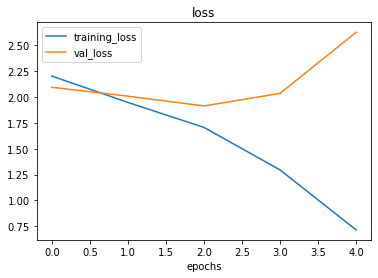

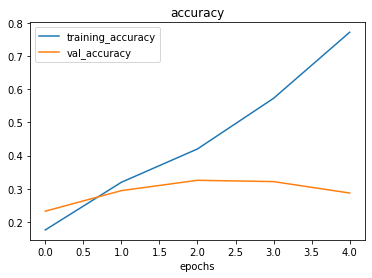

In [17]:
 # check the model's loss curve on the 10 classes of data
 plot_loss_curves(history_9)



Woah, that's quite the gap between the training and validation loss curves.

What does this tell us?

It seems our model is **overfitting** the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.


# 6. Adjus Model Parameters
So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

 - **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
 - **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
 - **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
 - **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

🔑 Note: Preventing overfitting is also referred to as **regularization**.

If you've already got an existing dataset, you're probably most likely to try one or a combination of the last three above options first.

Since collecting more data would involve us manually taking more images of food, let's try the ones we can do from right within the notebook.

How about we simplify our model first?

To do so, we'll remove two of the convolutional layers, taking the total number of convolutional layers from four to two.

In [18]:
# Try a simplified model (removed two layers)
model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 64s 265ms/step - loss: 2.1318 - accuracy: 0.2296 - val_loss: 1.9964 - val_accuracy: 0.2920
Epoch 2/5
235/235 [==============================] - 55s 234ms/step - loss: 1.7961 - accuracy: 0.3824 - val_loss: 1.9197 - val_accuracy: 0.3360
Epoch 3/5
235/235 [==============================] - 54s 229ms/step - loss: 1.3947 - accuracy: 0.5421 - val_loss: 2.0015 - val_accuracy: 0.3368
Epoch 4/5
235/235 [==============================] - 53s 224ms/step - loss: 0.9068 - accuracy: 0.7153 - val_loss: 2.1247 - val_accuracy: 0.3288
Epoch 5/5
235/235 [==============================] - 52s 222ms/step - loss: 0.4952 - accuracy: 0.8684 - val_loss: 2.4530 - val_accuracy: 0.3252


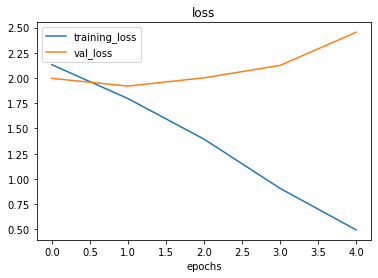

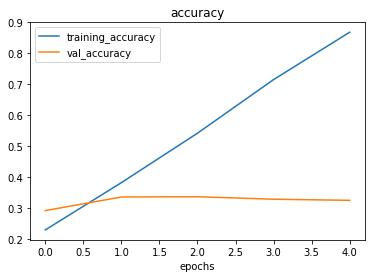

In [19]:
# Check out the loss curves of model_10
plot_loss_curves(history_10)

## Data Augmentation

In [20]:
# create augmented data generator instances
train_datagen_augmented = ImageDataGenerator(rescale=1/225.,
                                             rotation_range=20,
                                             width_shift_range=0.2, 
                                             height_shift_range = 0.2,
                                             zoom_range = 0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.




Now we've got augmented data, let's see how it works with the same model as before (model_10).

**Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called clone_model which can take an existing model and rebuild it in the same format.**

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

🔑 Note: One of the key practices in deep learning and machine learning in general is to be a serial experimenter. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.



In [22]:
# clone the model(use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# compile the cloned model
model_11.compile(loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# fit the model
history_11 = model_11.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch = len(train_data_augmented),
                          validation_data = test_data,
                          validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 157s 660ms/step - loss: 2.1774 - accuracy: 0.2097 - val_loss: 2.0070 - val_accuracy: 0.2880
Epoch 2/5
235/235 [==============================] - 134s 572ms/step - loss: 2.0418 - accuracy: 0.2820 - val_loss: 1.9284 - val_accuracy: 0.3240
Epoch 3/5
235/235 [==============================] - 135s 574ms/step - loss: 1.9932 - accuracy: 0.3051 - val_loss: 1.8284 - val_accuracy: 0.3588
Epoch 4/5
235/235 [==============================] - 131s 557ms/step - loss: 1.9515 - accuracy: 0.3304 - val_loss: 1.7647 - val_accuracy: 0.3864
Epoch 5/5
235/235 [==============================] - 129s 548ms/step - loss: 1.9212 - accuracy: 0.3328 - val_loss: 1.8400 - val_accuracy: 0.3688


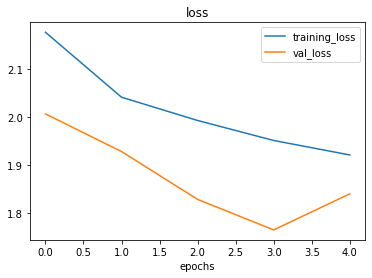

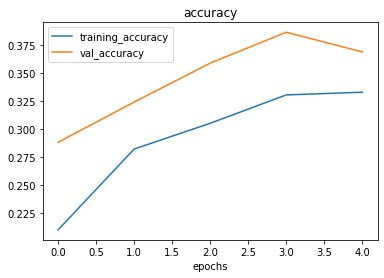

In [23]:
# check the model performance
plot_loss_curves(history_11)

In [26]:
# predict on the test data using model_9
model_9.evaluate(test_data)

79/79 [==============================] - 18s 222ms/step - loss: 2.6239 - accuracy: 0.2872


[2.62394118309021, 0.287200003862381]

In [27]:
# predict on the test data using model_11
model_11.evaluate(test_data)

79/79 [==============================] - 13s 158ms/step - loss: 1.8400 - accuracy: 0.3688


[1.840041995048523, 0.36880001425743103]

Woah! That's looking much better, the loss curves are much closer to eachother. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

It even looks like if we kept it training for longer (more epochs) the evaluation metrics might continue to improve.


# 7. Repeat Until Satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning.**

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class model.

### # 8. Making a Prediction using our Trained Model

In [28]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [29]:
# get our own custom data
# -q is for "quiet" 
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

In [33]:
def load_and_prep_image(filename, img_shape=224):
    """reads an image from filename, and turns it into a tensor and
    reshapes it to (imshape, img_shape, color_channels)"""
    
    # read in the image
    img = tf.io.read_file(filename)
    
    #decode the read file into a tensor
    img = tf.image.decode_image(img, channels=3)
    
    # resize the image
    img = tf.image.resize(img,size=[img_shape, img_shape])
    
    # rescale the image (get all the values between 0 and 1)
    img = img/225
    
    return img

In [34]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
    img = load_and_prep_image(filename)

  # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


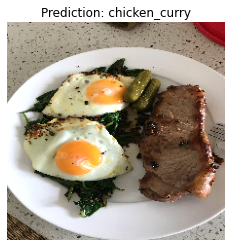

In [35]:
# Okay, we've got some custom images to try, let's use the pred_and_plot 
# function to make a prediction with model_11 on one of the images and plot it.

# Make a prediction using model_11
pred_and_plot(model=model_11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

I think it might have to do with our pred_and_plot function.

Let's makes a prediction without using the function and see where it might be going wrong.

The pred_and_plot function was designed to be used with binary classification models where as our current model is a multi-class classification model.

The main difference lies in the output of the predict function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


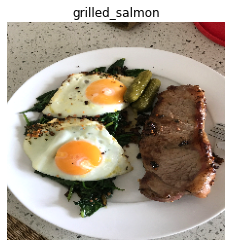

In [37]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

In [38]:
# Check the output of the predict function
pred = model_11.predict(tf.expand_dims(img, axis=0))
pred

array([[0.05905526, 0.0700535 , 0.01911531, 0.46880996, 0.01871282,
        0.03913508, 0.0080402 , 0.08275834, 0.1753511 , 0.05896834]],
      dtype=float32)



Since our model has a 'softmax' activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

The class with the highest probability is what the model believes the image contains.

We can find the maximum value index using argmax and then use that to index our class_names list to output the predicted class.


In [39]:
# Find the predicted class name
class_names[pred.argmax()]

'grilled_salmon'

Knowing this, we can readjust our pred_and_plot function to work with multiple classes as well as binary classes.

In [40]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Let's try it out. If we've done it right, using different images should lead to different outputs (rather than chicken_curry every time).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


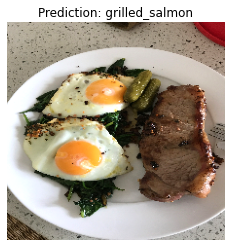

In [41]:
pred_and_plot(model_11, "03-steak.jpeg", class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


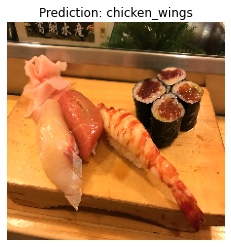

In [43]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


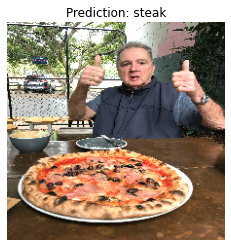

In [44]:
pred_and_plot(model_11, "03-pizza-dad.jpeg", class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


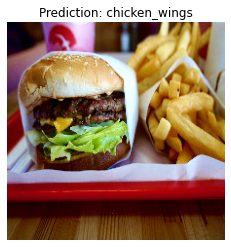

In [45]:
pred_and_plot(model_11, "03-hamburger.jpeg", class_names)

Our model's predictions aren't very good, this is because it's only performing at ~35% accuracy on the test dataset.

# Saving and Loading our Model
Once you've trained a model, you probably want to be able to save it and load it somewhere else.

To do so, we can use the save and load_model functions.

In [46]:
# Save a model
model_11.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


In [47]:
# Load in a model and evaluate it
loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
loaded_model_11.evaluate(test_data)

79/79 [==============================] - 17s 210ms/step - loss: 1.8400 - accuracy: 0.3688


[1.840041995048523, 0.36880001425743103]

In [48]:
# Compare our unsaved model's results (same as above)
model_11.evaluate(test_data)

79/79 [==============================] - 15s 196ms/step - loss: 1.8400 - accuracy: 0.3688


[1.840042233467102, 0.36880001425743103]